In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import signal
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# MNE Libraries
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs

In [2]:
# Define the plot output path
plot_output_path = Path('plot_outputs')

# Create directory if it doesn't exist
plot_output_path.mkdir(exist_ok=True)
print(f"Directory '{plot_output_path}' is ready.")

Directory 'plot_outputs' is ready.


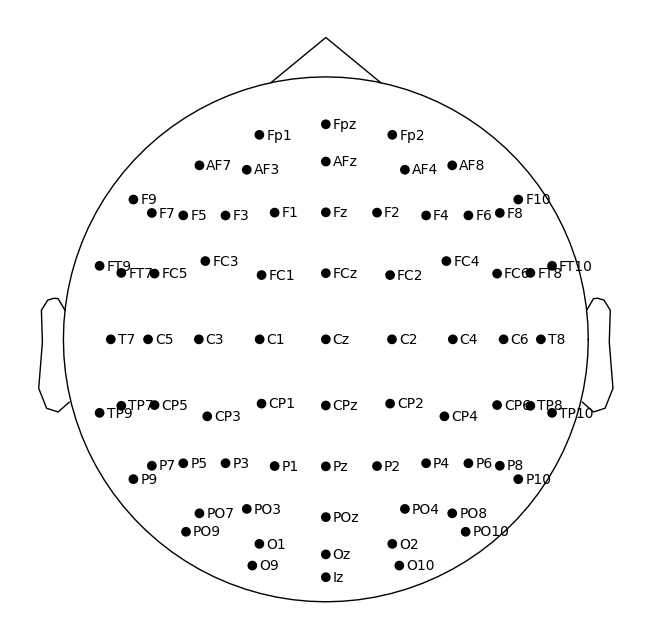

In [3]:
# Set montage
standard_1020_montage = mne.channels.make_standard_montage('easycap-M1')
standard_1020_montage.plot()
plt.show()

# Load Subject Information

In [4]:
# Subject Information
subject_info = pd.read_csv('data/subject_info.csv')

In [6]:
# Define the data directory
data_dir = Path('data')

# Initialize lists to store data
all_seizures = []
all_patients = []

# Load all JSON files from subdirectories
json_files = sorted(list(data_dir.glob('**/*.json')))  # ** searches subdirectories, sorted for consistent order
print(f"Found {len(json_files)} JSON files")
print("Files found:")
for f in json_files:
    print(f"  - {f}")
print("\nLoading data...")

for json_file in json_files:
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        # Extract patient-level information
        patient_info = {
            'patient_id': data['patient_id'],
            'sampling_rate_hz': data['sampling_rate_hz'],
            'num_channels': len(data['channels']),
            'json_file_path': str(json_file)  # Store the file path for reference
        }
        
        # Check if there's a top-level file_name (like PN01)
        if 'file_name' in data:
            patient_info['file_name'] = data['file_name']
            patient_info['registration_start_time'] = data.get('registration_start_time')
            patient_info['registration_end_time'] = data.get('registration_end_time')
        
        # Store patient info
        all_patients.append(patient_info)
        
        # Process each seizure
        for seizure in data['seizures']:
            seizure_record = {
                'patient_id': data['patient_id'],
                'sampling_rate_hz': data['sampling_rate_hz'],
                'seizure_number': seizure['seizure_number']
            }
            
            # Add all seizure fields dynamically to handle variations
            for key, value in seizure.items():
                seizure_record[key] = value
            
            # If file info is at patient level, add it to seizure record
            if 'file_name' in patient_info and 'file_name' not in seizure:
                seizure_record['file_name'] = patient_info['file_name']
                if 'registration_start_time' in patient_info:
                    seizure_record['registration_start_time'] = patient_info['registration_start_time']
                    seizure_record['registration_end_time'] = patient_info['registration_end_time']
            
            all_seizures.append(seizure_record)
            
    except Exception as e:
        print(f"Error loading {json_file}: {e}")
        continue

print("\nData loading complete!")

# Create DataFrames
seizures_df = pd.DataFrame(all_seizures)
patients_df = pd.DataFrame(all_patients)

Found 14 JSON files
Files found:
  - data\PN00\Seizures-list-PN00.json
  - data\PN01\Seizures-list-PN01.json
  - data\PN03\Seizures-list-PN03.json
  - data\PN05\Seizures-list-PN05.json
  - data\PN06\Seizures-list-PN06.json
  - data\PN07\Seizures-list-PN07.json
  - data\PN09\Seizures-list-PN09.json
  - data\PN10\Seizures-list-PN10.json
  - data\PN11\Seizures-list-PN11.json
  - data\PN12\Seizures-list-PN12.json
  - data\PN13\Seizures-list-PN13.json
  - data\PN14\Seizures-list-PN14.json
  - data\PN16\Seizures-list-PN16.json
  - data\PN17\Seizures-list-PN17.json

Loading data...

Data loading complete!


In [14]:
# Set subject to focus on
subject = 'PN00'

# Data Loading Functions

In [11]:
# Load raw edf
def load_edf_file(edf_path):
    # Read EDF file
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
        
    # Get available channels in the file
    available_channels = raw.ch_names

    raw.set_channel_types({'2':'ecg','1': 'ecg' })
    raw.rename_channels({'EEG Fp1':'Fp1', 'EEG F3':'F3', 'EEG C3':'C3', 'EEG P3':'P3', 'EEG O1':'O1', 
                'EEG F7':'F7', 'EEG T3':'C1', 'EEG T5':'T7', 'EEG Fc1':'FC1', 'EEG Fc5':'FC5', 'EEG Cp1':'CP1', 
                'EEG Cp5':'CP5', 'EEG F9':'F9', 'EEG Fz':'Fz', 'EEG Cz':'Cz', 'EEG Pz':'Pz', 'EEG Fp2':'Fp2', 
                'EEG F4':'F4', 'EEG C4':'C4', 'EEG P4':'P4', 'EEG O2':'O2', 'EEG F8':'F8', 'EEG T4':'C2', 
                'EEG T6':'T8', 'EEG Fc2':'FC2', 'EEG Fc6':'FC6', 'EEG Cp2':'CP2', 'EEG Cp6':'CP6', 
                'EEG F10':'F10', 'EKG EKG':'AF7', 'SPO2':'Iz', 'HR':'AF8', 'MK':'Fpz'})

    print(f"Successfully loaded {len(available_channels)} channels")
        
    return raw


In [12]:
raw = load_edf_file('data/PN01/PN01-1.edf')

Successfully loaded 35 channels


In [15]:
raw

<RawEDF | PN01-1.edf, 35 x 24861184 (48557.0 s), ~6.48 GiB, data loaded>

# Raw Data Plotting

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 s)

Using matplotlib as 2D backend.


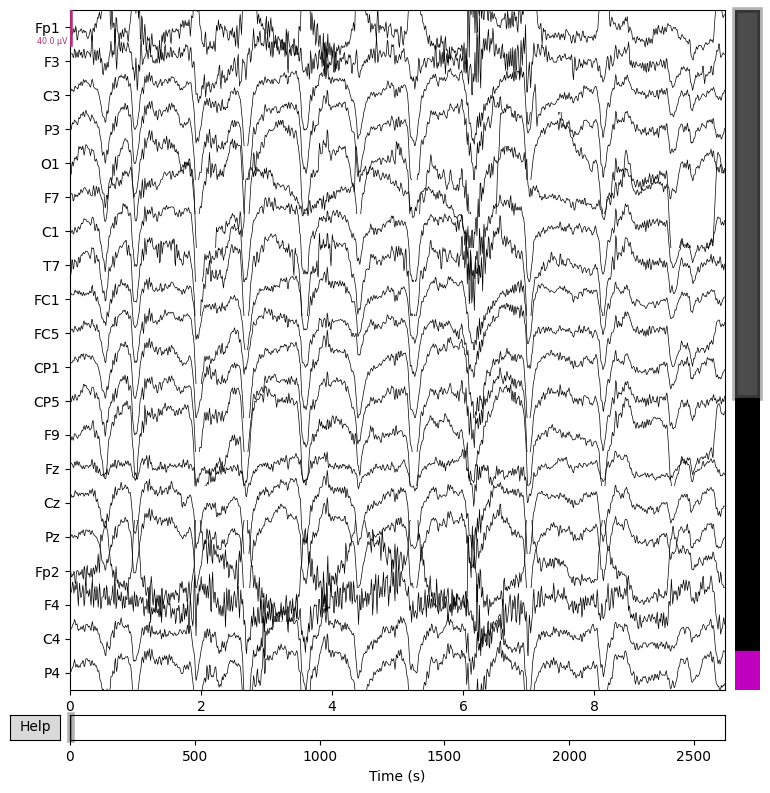

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 s)



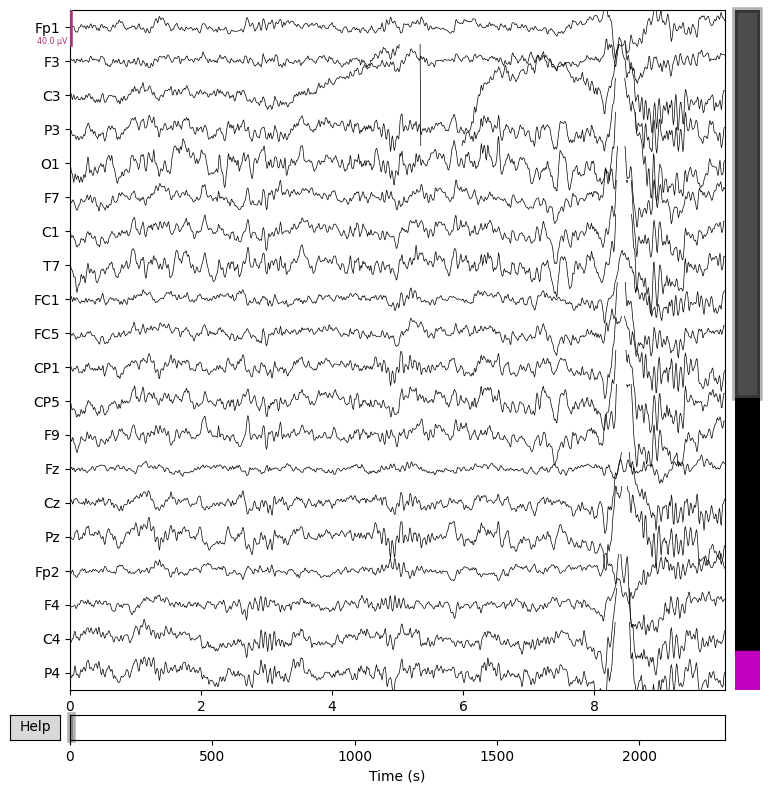

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 s)



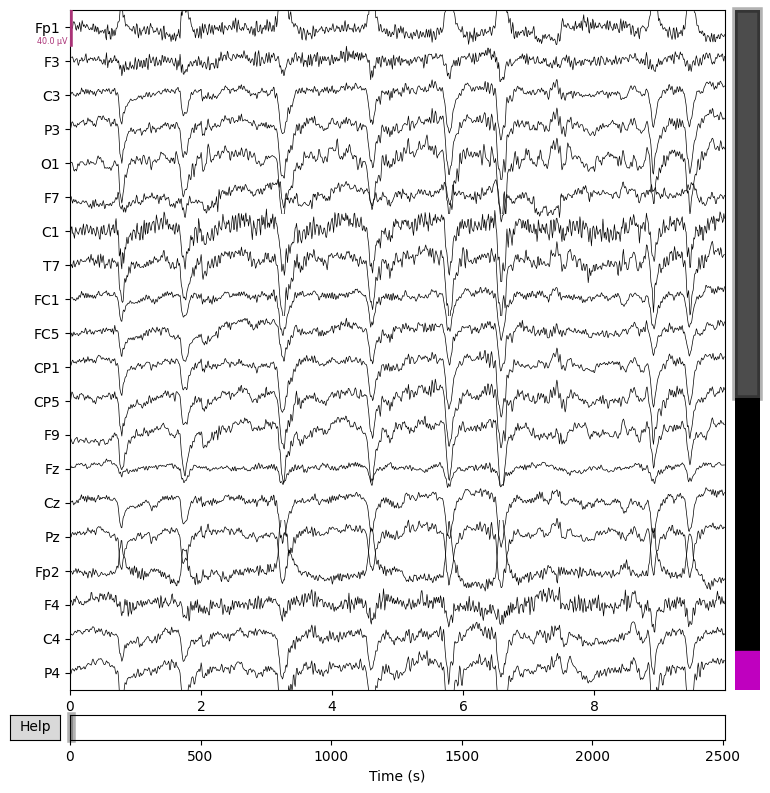

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 s)



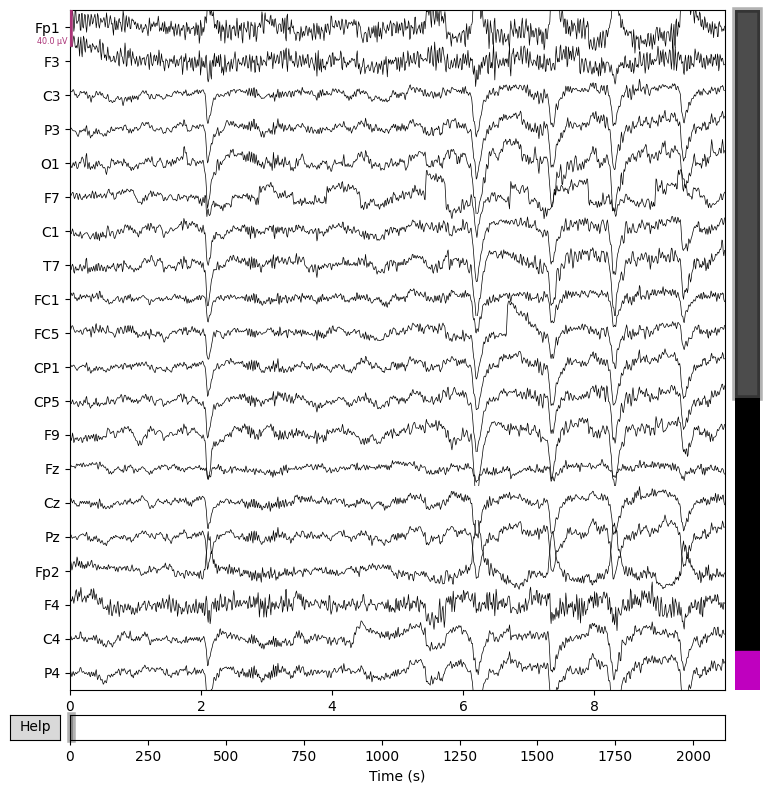

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 s)



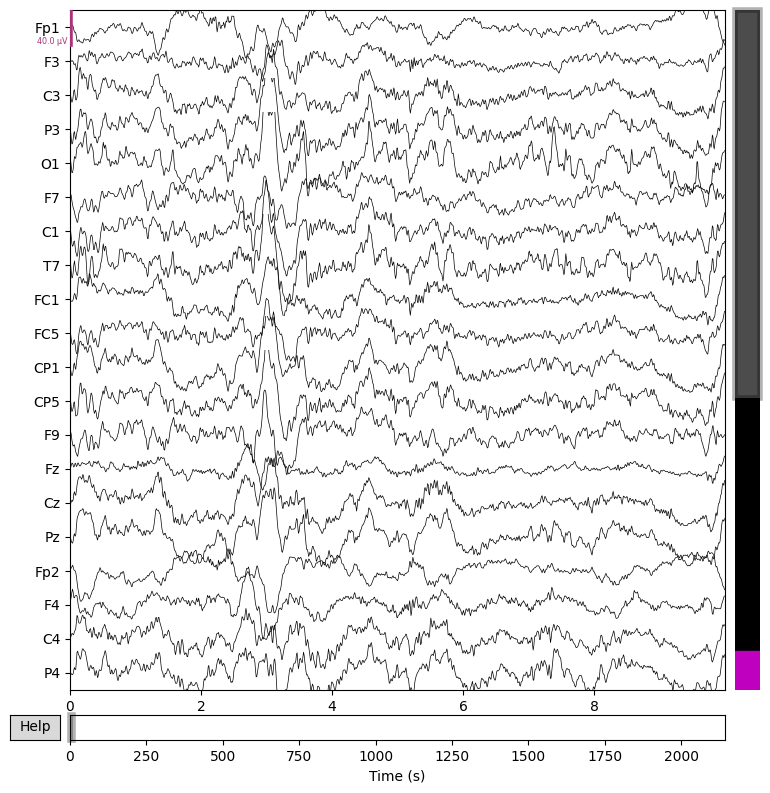

In [18]:
def plot_raw_data(subject_data, plot_output_path):
    # Iterate through each raw EDF file
    for i, raw in enumerate(subject_data['raw_data']):
        # Apply bandpass filter between 0.5 and 30 Hz
        raw.filter(0.5, 30, fir_design='firwin')

        # Plot the filtered data
        fig = raw.plot(
            show=True,
            title=f'Subject: {subject} - EDF File {i+1}'
            )
        
        # Save the plot to the specified path
        fig.savefig(plot_output_path / f'{subject}_raw_{i+1}_edf_plot.png')
        plt.close(fig)

    
plot_raw_data(subject_data, plot_output_path)